## Forecasting

In [1]:
# Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Databank 
import mysql.connector
from sqlalchemy import create_engine, exc


import itertools ### Modul, welches bestimmte Schleifen ermöglicht
import warnings  ###Modul, welches uns erlaubt, bestimmte Warnungen ein- und auszublenden

#Sonstige Module und Funktionen
from time import gmtime, strftime #Für die aktuelle Zeit


In [2]:
#Einstellen der Darstellungsoptionen

#Pandas - Mehr Zeilen und Spalten anzeigen
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

#Seaborn
sns.set_style("darkgrid")
plt.matplotlib.style.use('default')

my_colors = ["windows blue", "saffron", "hot pink", "algae green", "dusty purple", "greyish", "petrol", "denim blue", "lime"]
sns.set_palette(sns.xkcd_palette(my_colors))
colors = sns.xkcd_palette(my_colors)

#Warnings
warnings.filterwarnings("ignore")

#Connection-String für die Datenbank
str_db_typ = 'mysql+mysqlconnector://'
str_db_user = 'root'
str_db_password = ''
str_db_adr = '@localhost'
str_db_schema = '' 

In [4]:
### Sammlung aller selbstgeschriebenen Funktionen

#Mein Connection-String
def my_con_str(db_typ='mysql+mysqlconnector', db_user='root', db_passwort='', db_adr = 'localhost', db_schema = ''):
    '''Funktion, die einen DB-Connection-String zusammensetzt'''
    try:
        if len(db_schema) == 0:
            schema_sep = ''
            print('Achtung: Es wurde keine Datenbank angeben.')
        else:
            schema_sep ='/'                
        con_str = '{0}://{1}{2}@{3}{4}{5}'.format(db_typ, db_user, db_passwort, db_adr, schema_sep, db_schema)
        print('Connection: {}'.format(con_str))
        return con_str
    except:
        print('Etwas ist schief gelaufen. Bitte alle Parameter überprüfen.')
        con_str = ''
        return con_str
    

#Anlegen einer neuen Datenbank, falls diese noch nicht da ist.
def my_create_schema(dbname, con):
    engine = create_engine(con)
    engine.execute('CREATE DATABASE IF NOT EXISTS {}'.format(dbname))
    return


#Meine Datenzusammenfassung
def my_df_summary(data):
    '''Eigene Funktion für die Summary'''
    try:
        dat = data.copy()
        df = pd.DataFrame([dat.min(), dat.max(), dat.mean(), dat.std(), dat.isna().sum(), dat.nunique(), dat.dtypes],
                     index=['Minimum', 'Maximum', 'Mittelwert', 'Stand. Abw.','#NA', '#Uniques', 'dtypes'])        
        return df
    except:
        print('Es konnte keine Summary erstellt werden.')
        return data 



### Datenbank einrichten

In [5]:
con = my_con_str()

Achtung: Es wurde keine Datenbank angeben.
Connection: mysql+mysqlconnector://root@localhost


In [6]:
my_create_schema('timeseries',con)

In [7]:
con = my_con_str(db_schema='timeseries')

Connection: mysql+mysqlconnector://root@localhost/timeseries


### Datensatz

In [8]:
#Einlesen und anschauen des zu bearbeitenden Datensatzes
df = pd.read_excel(r'NYSE_sample.xlsx')

In [9]:
df.head()

,Date,AABA,AAPL,AMZN,AXP,BA,CAT,CSCO,CVX,DIS,GE,GOOGL,GS,HD,IBM,INTC,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,PFE,PG,TRV,UNH,UTX,VZ,WMT,XOM
0,2006-01-03,40.91,10.68,47.58,52.58,70.44,57.80,17.45,59.08,24.40,35.37,217.83,128.87,41.24,82.06,25.57,61.63,40.19,20.45,33.52,79.11,32.75,26.84,10.74,23.78,58.78,45.99,61.73,56.53,30.38,46.23,58.47
1,2006-01-04,40.97,10.71,47.25,51.95,71.17,59.27,17.85,58.91,23.99,35.32,222.84,127.09,40.48,81.95,25.91,62.58,39.62,20.41,33.82,78.71,33.13,26.97,10.69,24.55,58.89,46.50,61.88,56.19,31.27,46.32,58.57
2,2006-01-05,41.53,10.63,47.65,52.50,70.33,59.27,18.35,58.19,24.41,35.23,225.85,127.04,40.08,82.50,26.27,62.32,39.74,20.51,33.86,77.99,33.18,26.99,10.76,24.58,58.70,46.95,61.69,55.98,31.63,45.69,58.28
3,2006-01-06,43.21,10.90,47.87,52.68,69.35,60.45,18.77,59.25,24.74,35.47,233.06,128.84,40.38,84.95,26.31,62.60,40.02,20.70,34.06,78.63,33.12,26.91,10.72,24.85,58.64,47.21,62.90,56.16,31.35,45.88,59.43
4,2006-01-09,43.42,10.86,47.08,53.99,68.77,61.55,19.06,58.95,25.00,35.38,233.68,130.39,40.82,83.73,26.47,62.99,40.67,20.80,34.71,79.02,33.66,26.86,10.88,24.85,59.08,47.23,61.40,56.80,31.48,45.71,59.40


In [10]:
df = df.iloc[:,0:6]

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3020 entries, 0 to 3019
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3020 non-null   object 
 1   AABA    3019 non-null   float64
 2   AAPL    3019 non-null   float64
 3   AMZN    3019 non-null   float64
 4   AXP     3020 non-null   float64
 5   BA      3020 non-null   float64
dtypes: float64(5), object(1)
memory usage: 141.7+ KB


In [12]:
df.describe()

,AABA,AAPL,AMZN,AXP,BA
count,3019.000000,3019.000000,3019.000000,3020.000000,3020.000000
mean,28.412726,64.662892,299.376231,59.385315,101.515868
std,13.258163,44.536448,279.980161,19.371901,47.480903
min,8.950000,7.240000,26.070000,10.260000,29.360000
25%,16.130000,23.420000,81.090000,45.715000,70.600000
50%,27.100000,57.920000,205.440000,57.815000,85.490000
75%,36.635000,99.480000,375.140000,75.892500,130.615000
max,72.930000,176.420000,1195.830000,99.700000,297.900000


In [13]:
my_df_summary(df)

,Date,AABA,AAPL,AMZN,AXP,BA
Minimum,2006-01-03,8.95,7.24,26.07,10.26,29.36
Maximum,2017-12-29,72.93,176.42,1195.83,99.7,297.9
Mittelwert,NaN,28.4127,64.6629,299.376,59.3853,101.516
Stand. Abw.,NaN,13.2582,44.5364,279.98,19.3719,47.4809
#NA,0,1,1,1,0,0
#Uniques,3020,1960,2579,2901,2385,2556
dtypes,object,float64,float64,float64,float64,float64


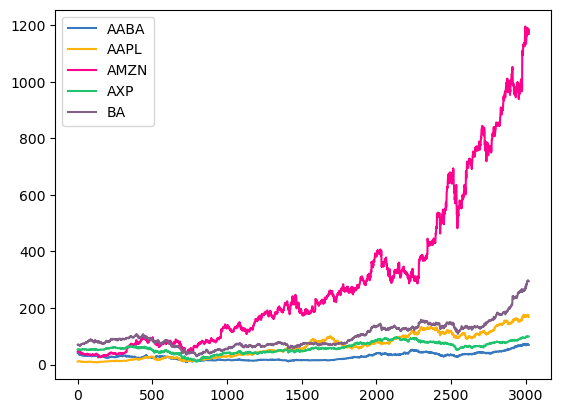

In [14]:
df.plot()

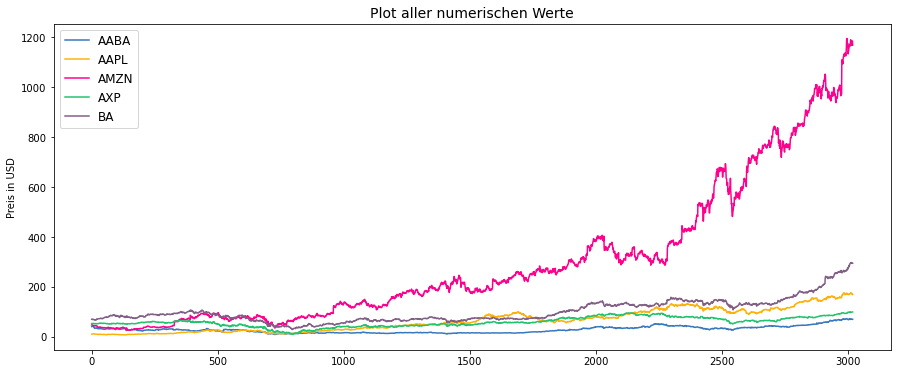

In [15]:
#Oder grafisch
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 6]
fig = df.plot(kind='line')
plt.title('Plot aller numerischen Werte', size=14)
plt.ylabel('Preis in USD')
plt.legend(fontsize=12)
plt.show()

### 1. Schritt: In welcher Frequenz liegen meine Zeitreihendaten vor?

In [17]:
df_ = df.copy()
              
s_Dates = pd.to_datetime(df_.iloc[:,0], format='%Y-%m-%d', errors='ignore')
        
#Mit "Nummer" des Wochentages
df_NuDay = pd.DataFrame(s_Dates.dt.dayofweek.value_counts(dropna=False))
df_NuDay = df_NuDay.reset_index()
df_NuDay.columns=['#Tag', 'Anzahl']
        
#Mit "Namen" des Wochentages
df_NaDay = pd.DataFrame(s_Dates.dt.day_name().value_counts(dropna=False))
df_NaDay = df_NaDay.reset_index()
df_NaDay.columns=['Tag', 'Anzahl']

In [19]:
df_NaDay

,Tag,Anzahl
0,Wednesday,622
1,Tuesday,618
2,Thursday,609
3,Friday,605
4,Monday,566


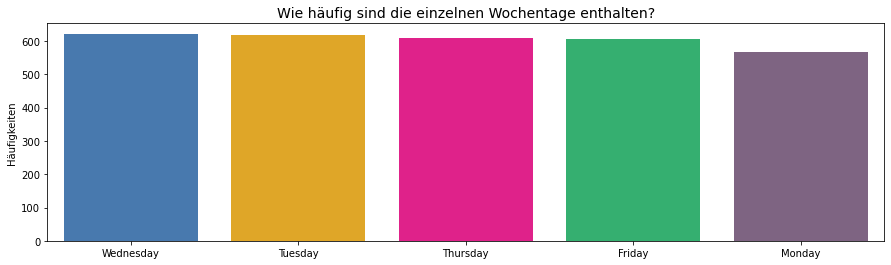

In [20]:
#Oder grafisch
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 4]
fig=sns.barplot(x='Tag', y='Anzahl', data=df_NaDay)
plt.title("Wie häufig sind die einzelnen Wochentage enthalten?", size=14)
plt.xlabel("")
plt.ylabel("Häufigkeiten")
plt.show()

### Aufbereiten der fehlenden Werte

In [22]:
#Das muss Zeitreihe für Zeitreihe individuell gemacht werden!
#Schritt 0: Auswahl einer Zeitreihe
df_ = df.iloc[:,0:2].copy() #Hier wähle ich den Index (Spalte 0) und die erste Datenspalte (Spalte 1) aus.

# df.iloc[:,[0,4]].copy() #So würde ich bspw. die 4. Datenspalte (Spalte 5) auswählen.

In [23]:
df_.head()

,Date,AABA
0,2006-01-03,40.91
1,2006-01-04,40.97
2,2006-01-05,41.53
3,2006-01-06,43.21
4,2006-01-09,43.42


In [24]:
#Cleansing
#Schritt 1:
l_colnames = df_.columns.to_list()
l_colnames[0] = 'Date'
df_.columns = l_colnames

df_['Date'] = pd.to_datetime(df_['Date'], format='%Y-%m-%d', errors='ignore')
daterange = pd.date_range(start=min(df_['Date']), end=max(df_['Date']), freq='B')
df_ts = pd.DataFrame(daterange)
df_ts.columns = ['Date']
df_ts = df_ts.merge(df_, how='left', on='Date')

#Schritt 2
print('{} fehlende Werte werden durch den zuletzt gültigen Wert ersetzt.'.format(df_ts.iloc[:,1].isna().sum()))
df_ts = df_ts.fillna(method='ffill')
df_ts = df_ts.set_index('Date', drop=True)

110 fehlende Werte werden durch den zuletzt gültigen Wert ersetzt.


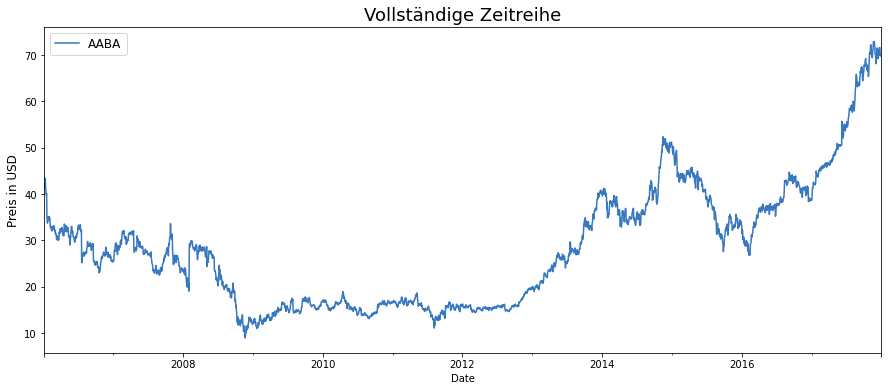

In [25]:
#Plotten der vollständigen Daten
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 6]
fig = df_ts.plot(kind='line')
plt.title('Vollständige Zeitreihe', size=18)
plt.legend(fontsize=12)
plt.ylabel('Preis in USD', size=12)
plt.show()

### Ausreißer erkennen

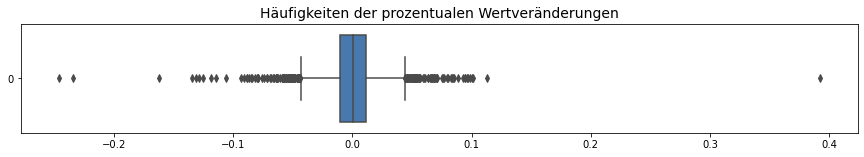

In [26]:
#Ausreißer Anzeigen - Für Zeitreihen NICHT entfernen.
#Ausreißer erkennt man in Zeitreihen an dem Verhalten der prozentualen Veränderungen zum jeweils vorherigen Wert.
%matplotlib inline
df_ = df.iloc[:,0:2].copy()
df_.iloc[:,1] = np.log(df_.iloc[:,1]) #Log-Differenzen sind die prozentualen Veränderungen
df_diff = df_.iloc[:,1].diff()

plt.rcParams['figure.figsize'] = [15, 2]

fig = sns.boxplot(data=df_diff, orient='h')

plt.title('Häufigkeiten der prozentualen Wertveränderungen', size=14)
plt.xlabel('')
plt.show()

In [27]:
i_iqr_faktor = 2
df_ = df.iloc[:,0:2].copy()
df_['Date'] = pd.to_datetime(df_['Date'], format='%Y-%m-%d', errors='ignore')
df_.iloc[:,1:] = np.log(df_.iloc[:,1:])
df_diff = df_.diff()


q25 = df_diff.iloc[:,1].quantile(0.25)
q75 = df_diff.iloc[:,1].quantile(0.75)

iqr = q75-q25

grenze_unten = q25 - (i_iqr_faktor*iqr)
grenze_oben = q75 + (i_iqr_faktor*iqr)
df_[((df_diff.iloc[:,1] < grenze_unten) | (df_diff.iloc[:,1] > grenze_oben))]




df_dates = df_[((df_diff.iloc[:,1] < grenze_unten) | (df_diff.iloc[:,1] > grenze_oben))]
df_dates = df_dates.reset_index()
df_dates = df_dates.iloc[:,0:2]
        
print('Bei den eingegebenen Daten und des IQR-Faktors sind Tage, an denen die Wertveränderung < {0:.2f} oder > {1:.2f} war, auffällig.'.format(grenze_unten, grenze_oben))
print('Dies tritt an {} Tagen auf: '.format(len(df_dates)))
df_dates

Bei den eingegebenen Daten und des IQR-Faktors sind Tage, an denen die Wertveränderung < -0.05 oder > 0.06 war, auffällig.
Dies tritt an 89 Tagen auf: 


,index,Date
0,10,2006-01-18
1,73,2006-04-19
2,136,2006-07-19
3,179,2006-09-19
4,265,2007-01-24
5,323,2007-04-18
6,335,2007-05-04
7,450,2007-10-17
8,457,2007-10-26
9,458,2007-10-29


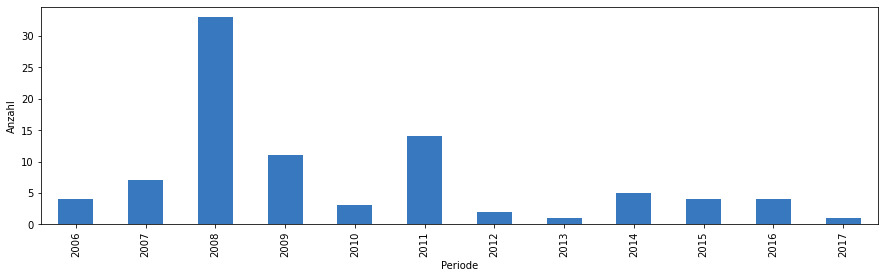

In [28]:
#Sind einzelne Jahre (Monate) besonders auffällig?
%matplotlib inline
df_dates['Jahr'] = df_dates['Date'].map(lambda x: x.strftime('%Y'))
plt.rcParams['figure.figsize'] = [15, 4]
df_dates.groupby('Jahr').size().plot(kind = 'bar')
plt.xlabel('Periode')
plt.ylabel('Anzahl')
plt.show()

In [29]:
#Zu untersuchende Daten auswählen
df_ts_clean = df_ts[df_ts.index > '2013-12-31']
print('Insgesamt liegen {} zusammenhängende ähnliche Beobachtungen vor.'.format(len(df_ts_clean)))

Insgesamt liegen 1043 zusammenhängende ähnliche Beobachtungen vor.


### Erzeugen eines Trainings- und eines Testdatensatzes

In [30]:
#Zerteilung in Trainings- und Testdaten - Im Normalfall beginnt man mit dem Verhältnis 80:20
#Weil wir Tagesdaten haben und mit "klassischen" Zeitreihenanalyseverfahren schwerlich mehr als 60 Perioden mit hoher
#Genauigkeit schätzen kann, teilen wir 95:5.

i_split = int(0.95*len(df_ts_clean))

df_train, df_test = df_ts_clean.iloc[:i_split,:], df_ts_clean.iloc[i_split:,:]

print('Train und Test sind zusammen {} Einträge lang.'.format(len(df_train)+len(df_test)))
print('D.h., alle Forecasts müssen {} Perioden lang sein.'.format(len(df_test)))

Train und Test sind zusammen 1043 Einträge lang.
D.h., alle Forecasts müssen 53 Perioden lang sein.


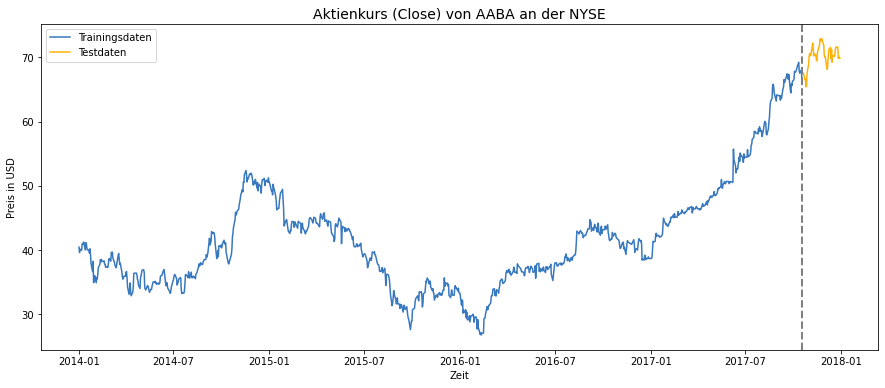

In [31]:
#Plot

plt.rcParams['figure.figsize'] = [15, 6]

plt.plot(df_train.index, df_train.values, label='Trainingsdaten')
plt.plot(df_test.index, df_test.values, label='Testdaten', color=colors[1])

plt.axvline(x = df_ts_clean.index[i_split], linewidth=2, color='grey', ls='--')
plt.legend(loc=2, fontsize=10)
plt.title('Aktienkurs (Close) von {} an der NYSE'.format(df_train.columns[0]), fontsize=14)
plt.xlabel('Zeit', fontsize=10)
plt.ylabel('Preis in USD', fontsize=10)
plt.show()

## Prognose-Verfahren

## Naiver Forecast - Einfaches Fortschreiben des letzten Wertes <br>

<font size="4">
\begin{align}
  \hat{y}_{t+1} &= y_{t}    
\end{align} <br>
</font>

In [33]:
vals = np.asarray(df_train.values)
y_hat = df_test.copy()
y_hat['naiv'] = vals[-1][0]

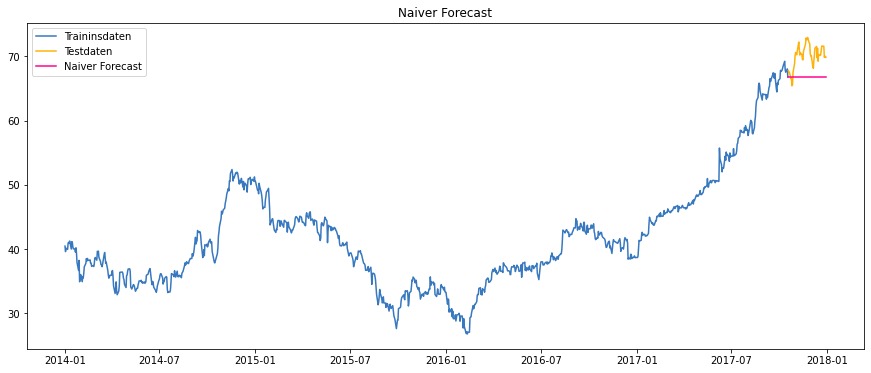

In [34]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 6]

plt.plot(df_train.index, df_train.values, label='Traininsdaten')
plt.plot(df_test.index, df_test.values, label='Testdaten')
plt.plot(y_hat.index, y_hat['naiv'], label='Naiver Forecast')
plt.legend(loc='best')
plt.title("Naiver Forecast")
plt.show()

### Wie lässt sich die Güte eines Forecasts bewerten?

### Root Mean Squared Error - RMSE
<font size="4">
Tipp: https://en.wikipedia.org/wiki/Root-mean-square_deviation <br>


\begin{align}
\text{RMSE}   \; &=  \sqrt{\frac{\sum_{t=1}^T (\hat{y}_t - y_t)^2}{T}}      
\end{align} <br>

Seltener schaut man auch einfach auch den durchschnittlichen Fehler.<br>

\begin{align*}
\text{ME}   \; &=  \frac{\sum_{t=1}^T (\hat{y}_t - y_t)}{T}
\end{align*} <br>

</font>

In [35]:
#Importieren der Fehler-Schätzstatistiken aus sklearn
from sklearn.metrics import mean_squared_error
from math import sqrt #Importieren einer Wurzel-Funktion aus math

In [36]:
rmse = sqrt(mean_squared_error(df_test, y_hat.naiv))
me = (df_test.iloc[:,0] - y_hat['naiv']).sum() / len(df_test)
print('Für den naiven Forecast ergeben sich ein ME: {0:.4f} und ein RMSE: {1:.4f}.'.format(me,rmse))

Für den naiven Forecast ergeben sich ein ME: 3.2947 und ein RMSE: 3.7385.


<font size=4>
Auch kann man die Güte es Forecasts an bestimmten Eigenschaften der Residuen (Schätzfehler) ablesen.<br>

\begin{align*}
\text{Residuen}   \; &=  \hat{y}_t - y_t \quad = \epsilon_t
\end{align*}

</font>

In [38]:
residuen = (df_test.iloc[:,0] - y_hat['naiv'])
print('Die Residuen haben für diesen Forecast folgene Standardabweichung: {0:.4f}.'.format(residuen.std()))
stdres = residuen.std()

Die Residuen haben für diesen Forecast folgene Standardabweichung: 1.7835.


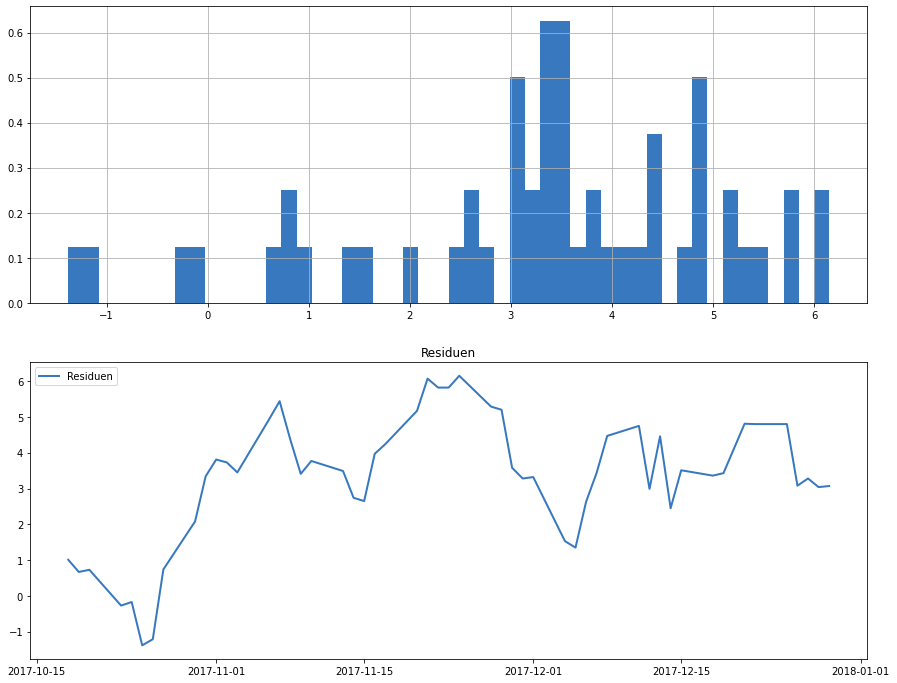

In [39]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 12]
plt.subplot(2,1,1)
residuen.hist(bins=50, density=True)
plt.subplot(2,1,2)
plt.plot(df_test.index, residuen.values, label='Residuen', linewidth=2)
plt.legend(loc=2)
plt.title("Residuen")
plt.show()

### Wie kann man Verfahren denn Vergleichen?

In [40]:
#Anlegen einer Tabelle, um später die Güte verschiedener Verfahren miteinander vergleichen zu können.
#ACHTUNG: Mit dieser Zeile wird ein leerer DataFrame erzeugt.
df_Fehler = pd.DataFrame(columns=['Methode', 'ME', 'RMSE', 'StdRes'])

In [41]:
#Einfügen der Güte-Maße
df_Fehler = df_Fehler.append({'Methode': 'Naives Fortschreiben', 'ME': me, 'RMSE': rmse, 'StdRes': stdres},
                             ignore_index=True)

In [42]:
df_Fehler

,Methode,ME,RMSE,StdRes
0,Naives Fortschreiben,3.294717,3.73847,1.78354


## Moving Average (Gleitender Mittelwert)

In [43]:
#Mit rolling und mean() kann man den gleitenden Mittelwert ganz einfach erzeugen. 
#Mit einer Schleife und append schreibt man die Werte fort.

n = 60 #Bspw. den gleitenden Durchschnitt über alle Handelstage des letzten Quartals.
df_train.rolling(n).mean().iloc[-1][0]

63.95716666666658

In [44]:
n = 60
df_mav = df_train.copy()
for i in range(len(df_test)):
    df_mav = df_mav.append({df_mav.columns[0] : df_mav.rolling(n).mean().iloc[-1][0]}, ignore_index=True)

In [45]:
y_hat = df_test.copy()
y_hat_mav = df_mav.iloc[-len(df_test):].copy()
y_hat['mav'] = y_hat_mav.values

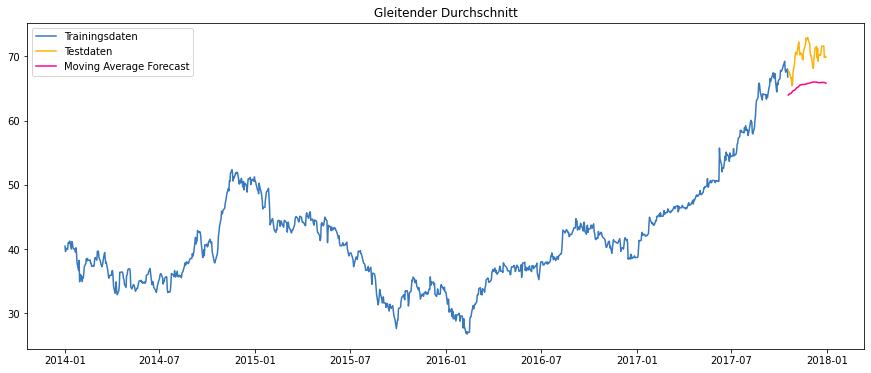

In [46]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 6]

plt.plot(df_train.index, df_train.values, label='Trainingsdaten')
plt.plot(df_test.index, df_test.values, label='Testdaten')
plt.plot(df_test.index, y_hat['mav'].values, label='Moving Average Forecast')

plt.title('Gleitender Durchschnitt')
plt.legend(loc='best')
plt.show()

In [47]:
rmse = sqrt(mean_squared_error(df_test, y_hat.mav))
me = (df_test.iloc[:,0] - y_hat['mav']).sum() / len(df_test)
print('Für den naiven Forecast ergeben sich ein ME: {0:.4f} und ein RMSE: {1:.4f}.'.format(me,rmse))

residuen = (df_test.iloc[:,0] - y_hat['mav'])
print('Die Residuen haben für diesen Forecast folgene Standardabweichung: {0:.4f}.'.format(residuen.std()))
stdres = residuen.std()

Für den naiven Forecast ergeben sich ein ME: 4.6000 und ein RMSE: 4.8247.
Die Residuen haben für diesen Forecast folgene Standardabweichung: 1.4691.


In [48]:
df_Fehler = df_Fehler.append({'Methode': 'Moving Average', 'ME': me, 'RMSE': rmse, 'StdRes': stdres},
                             ignore_index=True)

In [49]:
df_Fehler

,Methode,ME,RMSE,StdRes
0,Naives Fortschreiben,3.294717,3.738470,1.783540
1,Moving Average,4.600020,4.824714,1.469149


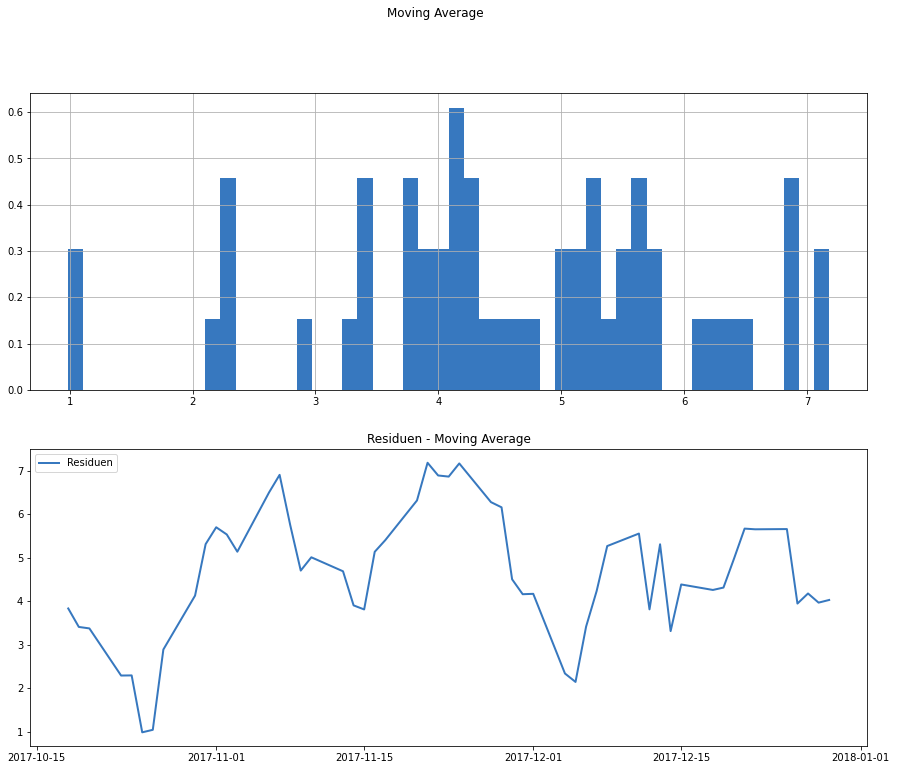

In [50]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 12]
plt.suptitle('Moving Average')
plt.subplot(2,1,1)
residuen.hist(bins=50, density=True)
plt.subplot(2,1,2)
plt.plot(df_test.index, residuen.values, label='Residuen', linewidth=2)
plt.legend(loc=2)
plt.title("Residuen - Moving Average")
plt.show()

<font size = 4>
Tipp: Wer sich intensiver mit der Mathematik hinter den meisten bekannten und etablierten Verfahren zur Zeitreihenen-Analyse beschäftigen möchte, kann sich u.a. hier einlesen: <br>

https://www.stat.berkeley.edu/~arturof/Teaching/STAT248/lab10_part1.html
</font>

### Exponentielle Glättung

<h3>Einfache (naive) exponentielle Glättung </h3><br>
<font size=4>
Für die einfache exponentielle Glättung gilt: <br><br>
\begin{align}
  \hat{y}_{t+1} &= \hat{y}_{t} + \alpha ( y_t - \hat{y}_{t})    
\end{align} <br>

Weil $\alpha$ zwischen 0 und 1 liegen muss, kann man die Gleichung umschreiben: <br><br>
\begin{align}
  \hat{y}_{t+1} &=  \alpha y_t + (1-\alpha) \hat{y}_{t}    
\end{align} <br>

Und das lässt sich schreiben als: <br><br>
\begin{align}
  \hat{y}_{t+1} &= \alpha y_{t} + \alpha(1-\alpha) y_{t-1} + \alpha(1-\alpha)^2 y_{t-2} + \cdots + \alpha(1-\alpha)^{t-1} y_{1} + \alpha(1-\alpha)^{t} \hat{y}_{1} 
\end{align} <br>
</font>

In [51]:
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [52]:
#Forecasts mit verschiedenen Glättungsparametern erzeugen
fit1 = SimpleExpSmoothing(df_train).fit(smoothing_level=0.25,optimized=False)
fcast1 = fit1.forecast(len(df_test)).rename(r'$\alpha=0.25$')


fit2 = SimpleExpSmoothing(df_train).fit(smoothing_level=0.50,optimized=False)
fcast2 = fit2.forecast(len(df_test)).rename(r'$\alpha=0.50$')


fit3 = SimpleExpSmoothing(df_train).fit()
fcast3 = fit3.forecast(len(df_test)).rename(r'$\alpha=%s$'%round(fit3.model.params['smoothing_level'],1))

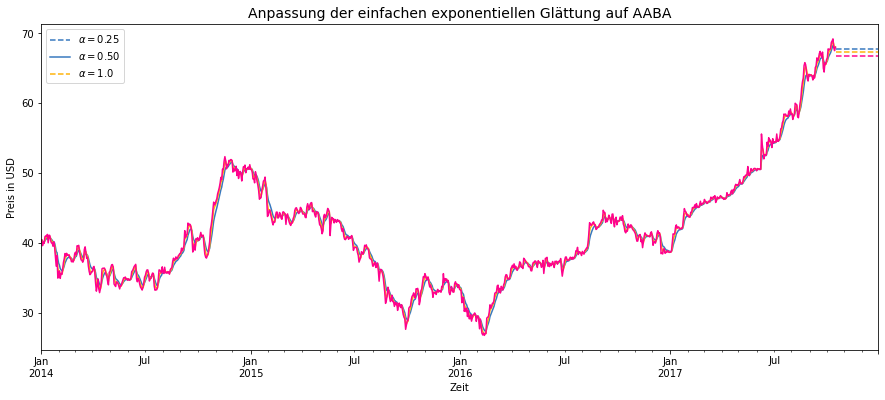

In [53]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 6]

fcast1.plot(legend=True, color=colors[0], ls='--')
fit1.fittedvalues.plot(color=colors[0])

fcast2.plot(legend=True, color=colors[1], ls='--')
fit2.fittedvalues.plot(color=colors[1])

fcast3.plot(legend=True, color=colors[2], ls='--')
fit3.fittedvalues.plot(color=colors[2])

plt.title('Anpassung der einfachen exponentiellen Glättung auf {}'.format(df_train.columns[0]), fontsize=14)
plt.xlabel('Zeit', fontsize=10)
plt.ylabel('Preis in USD', fontsize=10)

plt.show()

In [56]:
fit3.params

{'smoothing_level': 0.9779823062246565,
 'smoothing_slope': nan,
 'smoothing_seasonal': nan,
 'damping_slope': nan,
 'initial_level': 40.42145456370888,
 'initial_slope': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [57]:
rmse = sqrt(mean_squared_error(df_test, fcast1.values))
me = (df_test.iloc[:,0] - fcast1.values).sum() / len(df_test)
residuen = (df_test.iloc[:,0] - fcast1.values)
stdres = residuen.std()
print('Forecast 1   -   RMSE: {0:.4f}, ME: {1:.4f}, StdRes: {2:.4f}'.format(rmse, me, stdres))

Forecast 1   -   RMSE: 2.9550, ME: 2.3688, StdRes: 1.7835


In [58]:
df_Fehler = df_Fehler.append({'Methode': 'EinfExpGlätt 0.25', 'ME': me, 'RMSE': rmse, 'StdRes': stdres},
                             ignore_index=True)

In [59]:
rmse = sqrt(mean_squared_error(df_test, fcast2.values))
me = (df_test.iloc[:,0] - fcast2.values).sum() / len(df_test)
residuen = (df_test.iloc[:,0] - fcast2.values)
stdres = residuen.std()
print('Forecast 2   -   RMSE: {0:.4f}, ME: {1:.4f}, StdRes: {2:.4f}'.format(rmse, me, stdres))

Forecast 2   -   RMSE: 3.2135, ME: 2.6843, StdRes: 1.7835


In [60]:
df_Fehler = df_Fehler.append({'Methode': 'EinfExpGlätt 0.5', 'ME': me, 'RMSE': rmse, 'StdRes': stdres},
                             ignore_index=True)

In [61]:
rmse = sqrt(mean_squared_error(df_test, fcast3.values))
me = (df_test.iloc[:,0] - fcast3.values).sum() / len(df_test)
residuen = (df_test.iloc[:,0] - fcast3.values)
stdres = residuen.std()
print('Forecast 3   -   RMSE: {0:.4f}, ME: {1:.4f}, StdRes: {2:.4f}'.format(rmse, me, stdres))

Forecast 3   -   RMSE: 3.7143, ME: 3.2672, StdRes: 1.7835


In [62]:
df_Fehler = df_Fehler.append({'Methode': 'EinfExpGlätt 1', 'ME': me, 'RMSE': rmse, 'StdRes': stdres},
                             ignore_index=True)

In [63]:
df_Fehler

,Methode,ME,RMSE,StdRes
0,Naives Fortschreiben,3.294717,3.738470,1.783540
1,Moving Average,4.600020,4.824714,1.469149
2,EinfExpGlätt 0.25,2.368758,2.954997,1.783540
3,EinfExpGlätt 0.5,2.684340,3.213515,1.783540
4,EinfExpGlätt 1,3.267222,3.714261,1.783540


<h3>Exponentielle Glättung mit 'Level' und 'Trend' (Holt-Verfahren)</h3><br>
<font size=4>
Das Holt-Verfahren nennt man auch zweifache exponentielle Glättung:<br><br>

\begin{align*}
\text{Level: }   \; \quad \ell_t &=  \alpha y_t + (1-\alpha) (\ell_{t-1} + b_{t-1}) \\ \\
\text{Growth: }   \; \quad b_t &= \beta^* (\ell_t - \ell_{t-1}) + (1-\beta^*) b_{t-1} \\ \\
\text{Forecast: } \; \hat{y}_{t+h|t} &= \ell_t + b_t h \\ \\
\end{align*}

Manchmal wird der Trend auch gedämpft. <br><br>

\begin{align*}
\text{Level: }   \; \quad \ell_t &=  \alpha y_t + (1-\alpha) (\ell_{t-1} + \phi b_{t-1}) \\ \\
\text{Growth: }   \; \quad b_t &= \beta^* (\ell_t - \ell_{t-1}) + (1-\beta^*) b_{t-1} \\ \\
\text{Forecast: } \; \hat{y}_{t+h|t} &= \ell_t + (\phi + \phi^2 + \cdots + \phi^h) b_t h \\ \\
\end{align*}
</font>

In [64]:
#Schätzen der zweifachen exponentiellen Glättung
fit4 = Holt(df_train.iloc[:,0]).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
fcast4 = fit4.forecast(len(df_test)).rename("Holt's linear trend")

fit5 = Holt(df_train.iloc[:,0], exponential=True).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
fcast5 = fit5.forecast(len(df_test)).rename("Exponential trend")

fit6 = Holt(df_train.iloc[:,0], damped=True).fit()
fcast6 = fit6.forecast(len(df_test)).rename("Additive damped trend")

In [65]:
fit6.params

{'smoothing_level': 0.9044915581422307,
 'smoothing_slope': 1.0,
 'smoothing_seasonal': nan,
 'damping_slope': 0.04365336398134816,
 'initial_level': 40.46649733865921,
 'initial_slope': 0.0,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

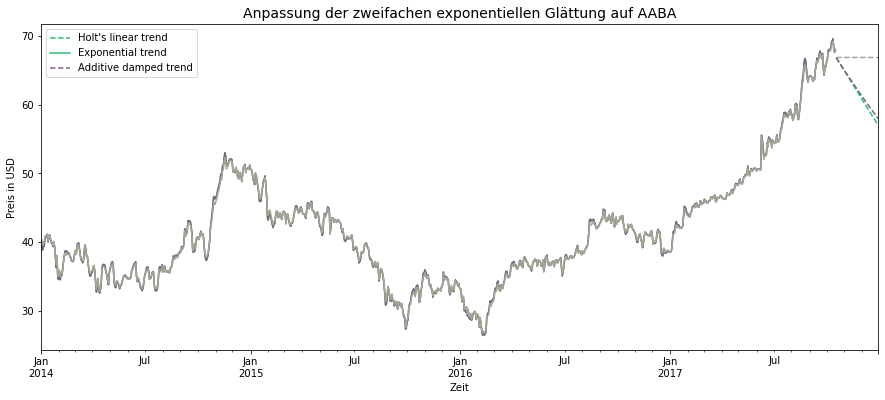

In [66]:
#Plotten der Ergebnisse

%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 6]

fcast4.plot(legend=True, color=colors[3], ls='--')
fit4.fittedvalues.plot(color=colors[3])

fcast5.plot(legend=True, color=colors[4], ls='--')
fit5.fittedvalues.plot(color=colors[4])

fcast6.plot(legend=True, color=colors[5], ls='--')
fit6.fittedvalues.plot(color=colors[5])

plt.title('Anpassung der zweifachen exponentiellen Glättung auf {}'.format(df_train.columns[0]), fontsize=14)
plt.xlabel('Zeit', fontsize=10)
plt.ylabel('Preis in USD', fontsize=10)

plt.show()

In [67]:
rmse = sqrt(mean_squared_error(df_test, fcast4.values))
me = (df_test.iloc[:,0] - fcast4.values).sum() / len(df_test)
residuen = (df_test.iloc[:,0] - fcast4.values)
stdres = residuen.std()
print('Forecast 4   -   RMSE: {0:.4f}, ME: {1:.4f}, StdRes: {2:.4f}'.format(rmse, me, stdres))

df_Fehler = df_Fehler.append({'Methode': 'Holt LT', 'ME': me, 'RMSE': rmse, 'StdRes': stdres},
                             ignore_index=True)

rmse = sqrt(mean_squared_error(df_test, fcast5.values))
me = (df_test.iloc[:,0] - fcast5.values).sum() / len(df_test)
residuen = (df_test.iloc[:,0] - fcast5.values)
stdres = residuen.std()
print('Forecast 5   -   RMSE: {0:.4f}, ME: {1:.4f}, StdRes: {2:.4f}'.format(rmse, me, stdres))

df_Fehler = df_Fehler.append({'Methode': 'Holt ET', 'ME': me, 'RMSE': rmse, 'StdRes': stdres},
                             ignore_index=True)

rmse = sqrt(mean_squared_error(df_test, fcast6.values))
me = (df_test.iloc[:,0] - fcast6.values).sum() / len(df_test)
residuen = (df_test.iloc[:,0] - fcast6.values)
stdres = residuen.std()
print('Forecast 6   -   RMSE: {0:.4f}, ME: {1:.4f}, StdRes: {2:.4f}'.format(rmse, me, stdres))

df_Fehler = df_Fehler.append({'Methode': 'Holt add, damped trend', 'ME': me, 'RMSE': rmse, 'StdRes': stdres},
                             ignore_index=True)

Forecast 4   -   RMSE: 9.0572, ME: 8.1390, StdRes: 4.0116
Forecast 5   -   RMSE: 8.6140, ME: 7.7632, StdRes: 3.7684
Forecast 6   -   RMSE: 3.6790, ME: 3.2271, StdRes: 1.7836


In [68]:
df_Fehler

,Methode,ME,RMSE,StdRes
0,Naives Fortschreiben,3.294717,3.738470,1.783540
1,Moving Average,4.600020,4.824714,1.469149
2,EinfExpGlätt 0.25,2.368758,2.954997,1.783540
3,EinfExpGlätt 0.5,2.684340,3.213515,1.783540
4,EinfExpGlätt 1,3.267222,3.714261,1.783540
5,Holt LT,8.138998,9.057173,4.011575
6,Holt ET,7.763224,8.613972,3.768397
7,"Holt add, damped trend",3.227057,3.679006,1.783596


<h3>Exponentielle Glättung mit 'Level', 'Trend' und 'Saisoneffekten' (Holt-Winters)</h3><br>
<font size=4>
Das Holt-Winters-Verfahren nennt man (spezielle) dreifache exponentielle Glättung:<br><br>

\begin{align*}
\text{Level: }   \; \quad \ell_t  &=  \alpha \frac{y_t}{s_{t-m}} + (1-\alpha) (\ell_{t-1} + b_{t-1}) \\\\
\text{Growth: }   \; \quad b_t  &= \beta^* (\ell_t - \ell_{t-1}) + (1-\beta^*) b_{t-1} \\\\
\text{Seasonal: } \; \quad  s_t &= \gamma  \frac{y_t}{\ell_{t-1} + b_{t-1}} + (1-\gamma) s_{t-m} \\\\
\text{Forecast: }\;  \hat{y}_{t+h|t}  &= (\ell_t + b_t h ) s_{t-m+h_m^+} \\
\end{align*}
</font>

In [70]:
#Schätzen von Holt-Winters
fit7 = ExponentialSmoothing(df_train.iloc[:,0], seasonal_periods=5, trend='add', seasonal='add').fit()
fcast7 = fit7.forecast(len(df_test)).rename("Holt-Winters Additive")

fit8 = ExponentialSmoothing(df_train.iloc[:,0], seasonal_periods=5, trend='add', seasonal='mul').fit()
fcast8 = fit8.forecast(len(df_test)).rename("Holt-Winters Multiplikativ")


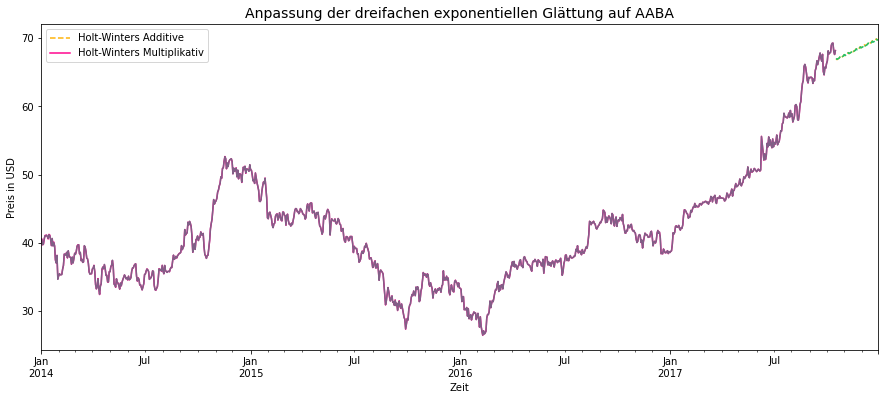

In [73]:
#Plotten der Ergebnisse

%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 6]

fcast7.plot(legend=True, color=colors[1], ls='--')
fit7.fittedvalues.plot(color=colors[2])

fcast8.plot(legend=True, color=colors[3], ls='--')
fit8.fittedvalues.plot(color=colors[4])

plt.title('Anpassung der dreifachen exponentiellen Glättung auf {}'.format(df_train.columns[0]), fontsize=14)
plt.xlabel('Zeit', fontsize=10)
plt.ylabel('Preis in USD', fontsize=10)

plt.show()

In [74]:
rmse = sqrt(mean_squared_error(df_test, fcast7.values))
me = (df_test.iloc[:,0] - fcast7.values).sum() / len(df_test)
residuen = (df_test.iloc[:,0] - fcast7.values)
stdres = residuen.std()
print('Forecast 7   -   RMSE: {0:.4f}, ME: {1:.4f}, StdRes: {2:.4f}'.format(rmse, me, stdres))

df_Fehler = df_Fehler.append({'Methode': 'Holt Winters add', 'ME': me, 'RMSE': rmse, 'StdRes': stdres},
                             ignore_index=True)

rmse = sqrt(mean_squared_error(df_test, fcast8.values))
me = (df_test.iloc[:,0] - fcast8.values).sum() / len(df_test)
residuen = (df_test.iloc[:,0] - fcast8.values)
stdres = residuen.std()
print('Forecast 8   -   RMSE: {0:.4f}, ME: {1:.4f}, StdRes: {2:.4f}'.format(rmse, me, stdres))

df_Fehler = df_Fehler.append({'Methode': 'Holt Winters mult', 'ME': me, 'RMSE': rmse, 'StdRes': stdres},
                             ignore_index=True)


Forecast 7   -   RMSE: 2.3152, ME: 1.6727, StdRes: 1.6160
Forecast 8   -   RMSE: 2.3310, ME: 1.6947, StdRes: 1.6158


In [75]:
df_Fehler

,Methode,ME,RMSE,StdRes
0,Naives Fortschreiben,3.294717,3.738470,1.783540
1,Moving Average,4.600020,4.824714,1.469149
2,EinfExpGlätt 0.25,2.368758,2.954997,1.783540
3,EinfExpGlätt 0.5,2.684340,3.213515,1.783540
4,EinfExpGlätt 1,3.267222,3.714261,1.783540
5,Holt LT,8.138998,9.057173,4.011575
6,Holt ET,7.763224,8.613972,3.768397
7,"Holt add, damped trend",3.227057,3.679006,1.783596
8,Holt Winters add,1.672665,2.315189,1.616035
9,Holt Winters mult,1.694724,2.331032,1.615823


## Faktor-Dekomposition
### Wie bekomme ich heraus, ob und welche Saisonalität in den Daten vorliegt?

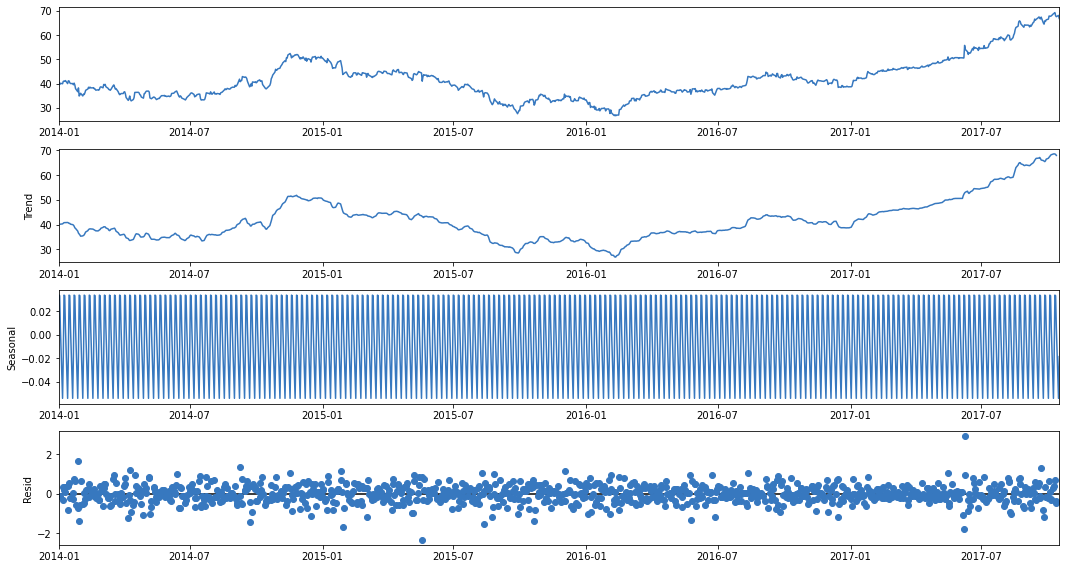

In [78]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 8]
sm.tsa.seasonal_decompose(df_train).plot()
plt.show()

## Autoregressive Prozesse AR, ARMA und ARIMA

<font size=4>
Tipp: Eine Einführung in ARIMA-Modelle findet sich hier:<br>
    
https://towardsdatascience.com/unboxing-arima-models-1dc09d2746f8

</font>

<h3>Autoregressive Prognose-Modelle</h3><br>
<font size=4>
Bei ARIMA-Modellen wird eine Zeitreihe durch einen verzögerten Term der zu erklärenden Variable (AR) und einen Moving-Average-Term (MA) erklärt. Unter bestimmten Umständen muss das Modell insgesamt als integrierte Gleichung (I; ein- oder mehrfach differenziert) optimiert werden.<br><br>
Dafür gilt es, die optimale Anzahl an Verzögerungen (p), das optimale Momentum (q) und, ggf., das optimale Differenz-Niveau (d) gefunden werden.<br>

\begin{align*}
\text{Forecast:} \; \quad \hat{y}_{t} &=  \mu + \phi_{1}y{t-1}+\cdots+\phi_{p}y_{t-p}-\theta_{1}\epsilon_{t-1}-\cdots-\theta_{q}\epsilon_{t-q} \\\\
\text{Für d = 0:} \; \quad y_t &= Y_t \\\\
\text{Für d = 1:} \; \quad y_t &= Y_t - Y_{t-1} \\\\
\text{Für d = 2:} \; \quad y_t &= (Y_t - Y_{t-1})-(Y_{t-1} - Y_{t-2})
\end{align*}
</font>

In [79]:
from statsmodels.tsa.arima_model import ARIMA
warnings.filterwarnings("ignore") # specify to ignore warning messages

In [80]:
#Eigene Auto-Arima-Funktion
#Erzeugen einer Liste von allen Parametern, die getestet werden sollen.
p = range(0, 6)
d = range(0, 3)
q = range(0, 5)
pdq = list(itertools.product(p, d, q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 4),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (0, 2, 4),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 0, 3),
 (1, 0, 4),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (1, 2, 3),
 (1, 2, 4),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 0, 3),
 (2, 0, 4),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2),
 (2, 2, 3),
 (2, 2, 4),
 (3, 0, 0),
 (3, 0, 1),
 (3, 0, 2),
 (3, 0, 3),
 (3, 0, 4),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3, 1, 3),
 (3, 1, 4),
 (3, 2, 0),
 (3, 2, 1),
 (3, 2, 2),
 (3, 2, 3),
 (3, 2, 4),
 (4, 0, 0),
 (4, 0, 1),
 (4, 0, 2),
 (4, 0, 3),
 (4, 0, 4),
 (4, 1, 0),
 (4, 1, 1),
 (4, 1, 2),
 (4, 1, 3),
 (4, 1, 4),
 (4, 2, 0),
 (4, 2, 1),
 (4, 2, 2),
 (4, 2, 3),
 (4, 2, 4),
 (5, 0, 0),
 (5, 0, 1),
 (5, 0, 2),
 (5, 0, 3),
 (5, 0, 4),
 (5, 1, 0),
 (5, 1, 1),
 (5, 1, 2),
 (5,

In [81]:
ts = df_train.copy()

In [82]:
AIC = []
ARIMA_model = []
i = 0

for param in pdq:
    try:
        mod = ARIMA(ts, order=param)
        results = mod.fit()
        print()     
        print(i, ": ",'ARIMA{} - AIC:{}'.format(param, results.aic), end='\r')
        AIC.append(results.aic)
        ARIMA_model.append([param])
    except:
        continue
    i = i + 1


0 :  ARIMA(0, 0, 0) - AIC:7013.454578932967
1 :  ARIMA(0, 0, 1) - AIC:5771.249334363882
2 :  ARIMA(0, 1, 0) - AIC:2151.2132474557666
3 :  ARIMA(0, 1, 1) - AIC:2152.659153522236
4 :  ARIMA(0, 1, 2) - AIC:2154.6282701671657
5 :  ARIMA(0, 1, 3) - AIC:2154.2940952408876
6 :  ARIMA(0, 1, 4) - AIC:2156.2916346441207
7 :  ARIMA(0, 2, 0) - AIC:2855.776649047264
8 :  ARIMA(0, 2, 1) - AIC:2155.557809569962
9 :  ARIMA(0, 2, 2) - AIC:2156.873683836948
10 :  ARIMA(0, 2, 3) - AIC:2158.8664849005554
11 :  ARIMA(0, 2, 4) - AIC:2158.185413456307
12 :  ARIMA(1, 0, 0) - AIC:2161.715398545889
13 :  ARIMA(1, 1, 0) - AIC:2152.652069831722
14 :  ARIMA(1, 1, 1) - AIC:2154.05849222667
15 :  ARIMA(1, 1, 2) - AIC:2156.00943161475
16 :  ARIMA(1, 1, 3) - AIC:2156.283781964605
17 :  ARIMA(1, 1, 4) - AIC:2158.1436481289193
18 :  ARIMA(1, 2, 0) - AIC:2554.3582284510103
19 :  ARIMA(1, 2, 1) - AIC:2156.868439790889
20 :  ARIMA(1, 2, 2) - AIC:2158.318046812955
21 :  ARIMA(1, 2, 4) - AIC:2159.039955302013
22 :  ARIMA(2,

In [83]:
print('Das AIC nimmt mit {} für das Modell ARIMA{} den kleinsten Wert an.'.format(min(AIC), ARIMA_model[AIC.index(min(AIC))][0]))

Das AIC nimmt mit 2147.873205912918 für das Modell ARIMA(4, 1, 4) den kleinsten Wert an.


In [84]:
mod = ARIMA(ts,order=ARIMA_model[AIC.index(min(AIC))][0])
fit9 = mod.fit()

In [86]:
#Achtung, wenn d != 0, dann werden Differenzen vorhergesagt.
fcast9 = fit9.predict(start=len(ts), end=len(ts)+len(df_test)-1, dynamic=False)
fcast9.head()

2017-10-18    0.112075
2017-10-19    0.178367
2017-10-20    0.254370
2017-10-23    0.075667
2017-10-24    0.274277
Freq: B, dtype: float64

In [87]:
y_hat_ = fcast9.copy()
y_hat_[0] = y_hat_[0] + ts.iloc[-1][0]
y_hat_ = np.cumsum(y_hat_.values)
fcast9[:] = y_hat_

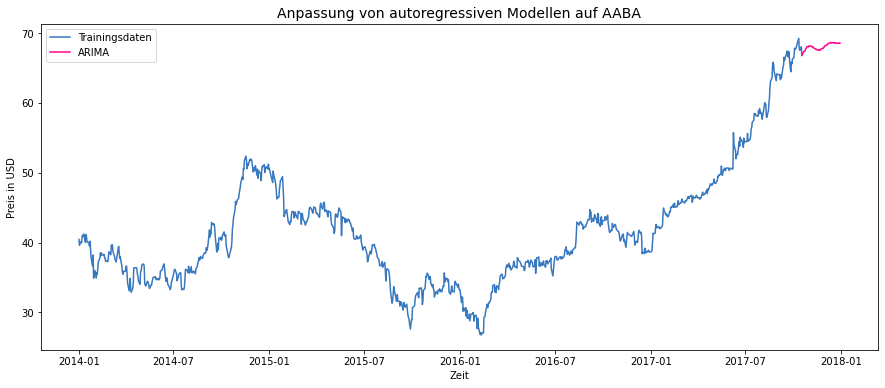

In [88]:
#Plotten der Ergebnisse

%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 6]

plt.plot(df_train.index, df_train.values, label='Trainingsdaten')
plt.plot(fcast9.index, fcast9.values, label='ARIMA', color=colors[2])

plt.legend(loc=2)
plt.title('Anpassung von autoregressiven Modellen auf {}'.format(df_train.columns[0]), fontsize=14)
plt.xlabel('Zeit', fontsize=10)
plt.ylabel('Preis in USD', fontsize=10)

plt.show()

In [91]:
rmse = sqrt(mean_squared_error(df_test, fcast9.values))
me = (df_test.iloc[:,0] - fcast9.values).sum() / len(df_test)
residuen = (df_test.iloc[:,0] - fcast9.values)
stdres = residuen.std()
print('Forecast 7   -   RMSE: {0:.4f}, ME: {1:.4f}, StdRes: {2:.4f}'.format(rmse, me, stdres))

df_Fehler = df_Fehler.append({'Methode': 'ARIMA(4,1,4)', 'ME': me, 'RMSE': rmse, 'StdRes': stdres},
                             ignore_index=True)

Forecast 7   -   RMSE: 2.6475, ME: 2.0076, StdRes: 1.7424


In [92]:
df_Fehler

,Methode,ME,RMSE,StdRes
0,Naives Fortschreiben,3.294717,3.738470,1.783540
1,Moving Average,4.600020,4.824714,1.469149
2,EinfExpGlätt 0.25,2.368758,2.954997,1.783540
3,EinfExpGlätt 0.5,2.684340,3.213515,1.783540
4,EinfExpGlätt 1,3.267222,3.714261,1.783540
5,Holt LT,8.138998,9.057173,4.011575
6,Holt ET,7.763224,8.613972,3.768397
7,"Holt add, damped trend",3.227057,3.679006,1.783596
8,Holt Winters add,1.672665,2.315189,1.616035
9,Holt Winters mult,1.694724,2.331032,1.615823
